# 003.0 - Rank Probability Score

Rank Probability Score

Pinnacle Odds

Rank Probability Skill Score

In [2]:
import pathlib
import sys
from typing import List, Tuple, Union, Callable
from types import ModuleType

from statsmodels.graphics.mosaicplot import mosaic
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline

sys.path.append('..')
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.data.utils import make_interim_data, get_clean_season, get_interim_data_fps

In [4]:
# Get the file path list from the interim data dir
fl = get_interim_data_fps()
# Extract a single season from the interim data
season = get_clean_season(fl[0], '2012-2013')
season.sort_values(by='date')
season.head()

,date,season,h,a,h_goals,a_goals,h_shots,a_shots,h_sot,a_sot,hwin_odds,draw_odds,awin_odds,result,h_phwinodds,a_pdrawodds,a_pawinodds
0,2012-08-18,2012-2013,Arsenal,Sunderland,0,0,14,3,4,2,1.44,4.72,8.71,draw,0.680082,0.207482,0.112436
1,2012-08-18,2012-2013,Fulham,Norwich,5,0,11,4,9,2,1.84,3.75,4.75,hwin,0.532471,0.261266,0.206263
2,2012-08-18,2012-2013,Newcastle,Tottenham,2,1,6,12,4,6,2.83,3.35,2.72,hwin,0.346594,0.292795,0.360611
3,2012-08-18,2012-2013,QPR,Swansea,0,5,20,12,11,8,2.00,3.53,4.15,awin,0.488162,0.276579,0.235259
4,2012-08-18,2012-2013,Reading,Stoke,1,1,9,6,3,3,2.47,3.30,3.22,draw,0.397525,0.297541,0.304934


## RPS

[Met Office? Online Course](https://www.met-learning.eu/pluginfile.php/5277/mod_resource/content/6/www/english/courses/msgcrs/index.htm)

Rank Probability Score (RPS) measures the accuracy of probability predictions when there are more than 2 categories (For 2 categories use the Brier Score)

$$RPS = \frac{1}{K - 1}\sum_{k=0}^K (CDF_{pred,k} - CDF_{obs,k})^2$$

where:
- there are K Categories
- CDF is Cumulative Distribution of the prediction, and the observed
- RPS has a range from 0 to 1
- Lower is better


### Test Data

In [5]:
# Test Data form Met Office? Online Course Page - Computation of the Rank Probability Score (RPS) – Accuracy

d = {'p1': [0.7, 0.9, 0.9, 0.8, 0.8, 0.9, 0.6, 0.3, 0.3,0.8, 0.8, 0.0, 0.3],
     'p2': [0.3, 0.1, 0.1, 0.2, 0.2, 0.1, 0.4, 0.4, 0.4, 0.2, 0.2, 0.4, 0.7],
     'p3': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.3, 0.0, 0.0, 0.6, 0.0],
     'obs_cat': [1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 3 ,2],
     'obs_cat1': [1,1,1,1,1,1,0,0,1,1,0,0,0],
     'obs_cat2': [0,0,0,0,0,0,1,1,0,0,1,0,1],
     'obs_cat3': [0,0,0,0,0,0,0,0,0,0,0,1,0],
     'rps': [0.045, 0.005, 0.005, 0.020, 0.020, 0.005, 0.180, 0.090, 0.29, 0.020, 0.320, 0.080, 0.045]}
df_test = pd.DataFrame(d)
df_test.head(20)


,p1,p2,p3,obs_cat,obs_cat1,obs_cat2,obs_cat3,rps
0,0.7,0.3,0.0,1,1,0,0,0.045
1,0.9,0.1,0.0,1,1,0,0,0.005
2,0.9,0.1,0.0,1,1,0,0,0.005
3,0.8,0.2,0.0,1,1,0,0,0.020
4,0.8,0.2,0.0,1,1,0,0,0.020
5,0.9,0.1,0.0,1,1,0,0,0.005
6,0.6,0.4,0.0,2,0,1,0,0.180
7,0.3,0.4,0.3,2,0,1,0,0.090
8,0.3,0.4,0.3,1,1,0,0,0.290
9,0.8,0.2,0.0,1,1,0,0,0.020


### Calculation

In [6]:
def calc_rps(pred_df: pd.DataFrame, obs_df: pd.DataFrame) -> pd.Series:
    """
    Accepts two DataFrames - DataFrames must be same size
    pred_df contains probability predictions of outcomes in ranked order
    obs_df contains 0 or 1 based on the observed outcome where the 
    outcomes are in the same ranked order
    Return the Rank Probability Score for each row inside a series
    """
    #print(pred_df.values)
    pred_cdf = pred_df.cumsum(axis='columns').values
    # print(pred_cdf)
    obs_cdf = obs_df.cumsum(axis='columns').values
    # RPS = (pred_cdf - obs_cdf)**2
    RPS = pd.Series(np.sum(1/(pred_df.shape[1]-1) * (pred_cdf - obs_cdf)**2, 1), name='RPS')
    return RPS
    
RPS = calc_rps(df_test[['p1','p2', 'p3']], df_test[['obs_cat1','obs_cat2', 'obs_cat3']])
print(f'RPS vector:\n{RPS}\n')
    
mean_RPS = RPS.mean()
print(f'Mean RPS: {mean_RPS}\n')

gmean_RPS = stats.gmean(RPS)
# print(f'Geometric Mean RPS: {gmean_RPS}\n')

hmean_RPS = stats.hmean(RPS)
# print(f'Harmonic Mean RPS: {hmean_RPS}\n')

sum_RPS = RPS.sum()
print(f'Sum RPS: {sum_RPS}')

RPS vector:
0     0.045
1     0.005
2     0.005
3     0.020
4     0.020
5     0.005
6     0.180
7     0.090
8     0.290
9     0.020
10    0.320
11    0.080
12    0.045
Name: RPS, dtype: float64

Mean RPS: 0.08653846153846154

Sum RPS: 1.125


### Pinnacle Odds RPS

In [10]:
df = season.copy(deep=True)
# Apply to Pinnacle Odds

# One hot encode the result
df_coded = pd.concat([pd.get_dummies(df['result']),
                      df[['h_phwinodds', 'a_pdrawodds', 'a_pawinodds']],
                      df[['h', 'a']]],
                      axis=1)
df_coded = df_coded[['h', 'a', 'hwin', 'draw', 'awin', 'h_phwinodds', 'a_pdrawodds', 'a_pawinodds']]
df_coded.head()

,h,a,hwin,draw,awin,h_phwinodds,a_pdrawodds,a_pawinodds
0,Arsenal,Sunderland,0,1,0,0.680082,0.207482,0.112436
1,Fulham,Norwich,1,0,0,0.532471,0.261266,0.206263
2,Newcastle,Tottenham,1,0,0,0.346594,0.292795,0.360611
3,QPR,Swansea,0,0,1,0.488162,0.276579,0.235259
4,Reading,Stoke,0,1,0,0.397525,0.297541,0.304934


In [11]:
df_coded['pinn_RPS'] = calc_rps(df_coded[['hwin', 'draw', 'awin']],
                           df_coded[['h_phwinodds', 'a_pdrawodds', 'a_pawinodds']])

df_coded.head()

,h,a,hwin,draw,awin,h_phwinodds,a_pdrawodds,a_pawinodds,pinn_RPS
0,Arsenal,Sunderland,0,1,0,0.680082,0.207482,0.112436,0.237576
1,Fulham,Norwich,1,0,0,0.532471,0.261266,0.206263,0.130564
2,Newcastle,Tottenham,1,0,0,0.346594,0.292795,0.360611,0.278490
3,QPR,Swansea,0,0,1,0.488162,0.276579,0.235259,0.411566
4,Reading,Stoke,0,1,0,0.397525,0.297541,0.304934,0.125505


In [12]:
sum_pinn_RPS = df_coded['pinn_RPS'].sum()
sum_pinn_RPS

70.33035527208766

### Historical Probabilities RPS

In [14]:
# Get the file path list from the interim data dir
fl = get_interim_data_fps()
# Extract a single season from the interim data
season = get_clean_season(fl[0], '2012-2013')
season.sort_values(by='date')
df = season.copy(deep=True)
results = df['result'].value_counts()/len(df['result'])
print(results, '\n')

hwin    0.436842
draw    0.284211
awin    0.278947
Name: result, dtype: float64 



In [15]:
df_coded['p_hwin_hist'] = results[0]
df_coded['p_draw_hist'] = results[1]
df_coded['p_awin_hist'] = results[2]
df_coded.head()

,h,a,hwin,draw,awin,h_phwinodds,a_pdrawodds,a_pawinodds,pinn_RPS,p_hwin_hist,p_draw_hist,p_awin_hist
0,Arsenal,Sunderland,0,1,0,0.680082,0.207482,0.112436,0.237576,0.436842,0.284211,0.278947
1,Fulham,Norwich,1,0,0,0.532471,0.261266,0.206263,0.130564,0.436842,0.284211,0.278947
2,Newcastle,Tottenham,1,0,0,0.346594,0.292795,0.360611,0.278490,0.436842,0.284211,0.278947
3,QPR,Swansea,0,0,1,0.488162,0.276579,0.235259,0.411566,0.436842,0.284211,0.278947
4,Reading,Stoke,0,1,0,0.397525,0.297541,0.304934,0.125505,0.436842,0.284211,0.278947


In [16]:
df_coded['hist_RPS'] = calc_rps(df_coded[['hwin', 'draw', 'awin']],
                           df_coded[['p_hwin_hist', 'p_draw_hist', 'p_awin_hist']])

df_coded.head()

,h,a,hwin,draw,awin,h_phwinodds,a_pdrawodds,a_pawinodds,pinn_RPS,p_hwin_hist,p_draw_hist,p_awin_hist,hist_RPS
0,Arsenal,Sunderland,0,1,0,0.680082,0.207482,0.112436,0.237576,0.436842,0.284211,0.278947,0.134321
1,Fulham,Norwich,1,0,0,0.532471,0.261266,0.206263,0.130564,0.436842,0.284211,0.278947,0.197479
2,Newcastle,Tottenham,1,0,0,0.346594,0.292795,0.360611,0.278490,0.436842,0.284211,0.278947,0.197479
3,QPR,Swansea,0,0,1,0.488162,0.276579,0.235259,0.411566,0.436842,0.284211,0.278947,0.355374
4,Reading,Stoke,0,1,0,0.397525,0.297541,0.304934,0.125505,0.436842,0.284211,0.278947,0.134321


In [17]:
sum_hist_RPS = df_coded['hist_RPS'].sum()
sum_hist_RPS

84.95789473684212

## RPS Skill Score

Skill scores have a range from - infinity to 1

Negative values indicate the predictions are less accurate than the benchmark predictions

Perfect RPS = 0


$$RPSS = \frac{1 - RPS}{RPS_b}$$

where $RPS_b$ is the Benchmark RPS Score

We will put the Pinnacle RPS as the benchmark, and calculate a skill score for each game

We will always keep the Pinnacle RPS as a benchmark because we want to do better than Pinnacle

In [18]:
def calc_rps_ss(rps: pd.Series, rps_b: pd.Series) -> pd.Series:
    """
    Accepts two Series - must be same length
    rps contains rank probability scores for individual events
    rps_b contains benchmark rank probability scores for individual events
    Return the Rank Probability Skill Score for each event as a Series
    """
    RPS_SS = (1 - rps) / rps_b
    return RPS_SS
    
df_coded['RPS_SS'] = calc_rps_ss(df_coded['hist_RPS'], df_coded['pinn_RPS'])
#df_coded['RPS_SS'] = calc_rps_ss(df_coded['pinn_RPS'], df_coded['hist_RPS'])

df_coded.head()

,h,a,hwin,draw,awin,h_phwinodds,a_pdrawodds,a_pawinodds,pinn_RPS,p_hwin_hist,p_draw_hist,p_awin_hist,hist_RPS,RPS_SS
0,Arsenal,Sunderland,0,1,0,0.680082,0.207482,0.112436,0.237576,0.436842,0.284211,0.278947,0.134321,3.643791
1,Fulham,Norwich,1,0,0,0.532471,0.261266,0.206263,0.130564,0.436842,0.284211,0.278947,0.197479,6.146588
2,Newcastle,Tottenham,1,0,0,0.346594,0.292795,0.360611,0.278490,0.436842,0.284211,0.278947,0.197479,2.881690
3,QPR,Swansea,0,0,1,0.488162,0.276579,0.235259,0.411566,0.436842,0.284211,0.278947,0.355374,1.566278
4,Reading,Stoke,0,1,0,0.397525,0.297541,0.304934,0.125505,0.436842,0.284211,0.278947,0.134321,6.897546


In [19]:
RPS_SS_sum = df_coded['RPS_SS'].sum()
RPS_SS_sum

3088.1151938823523

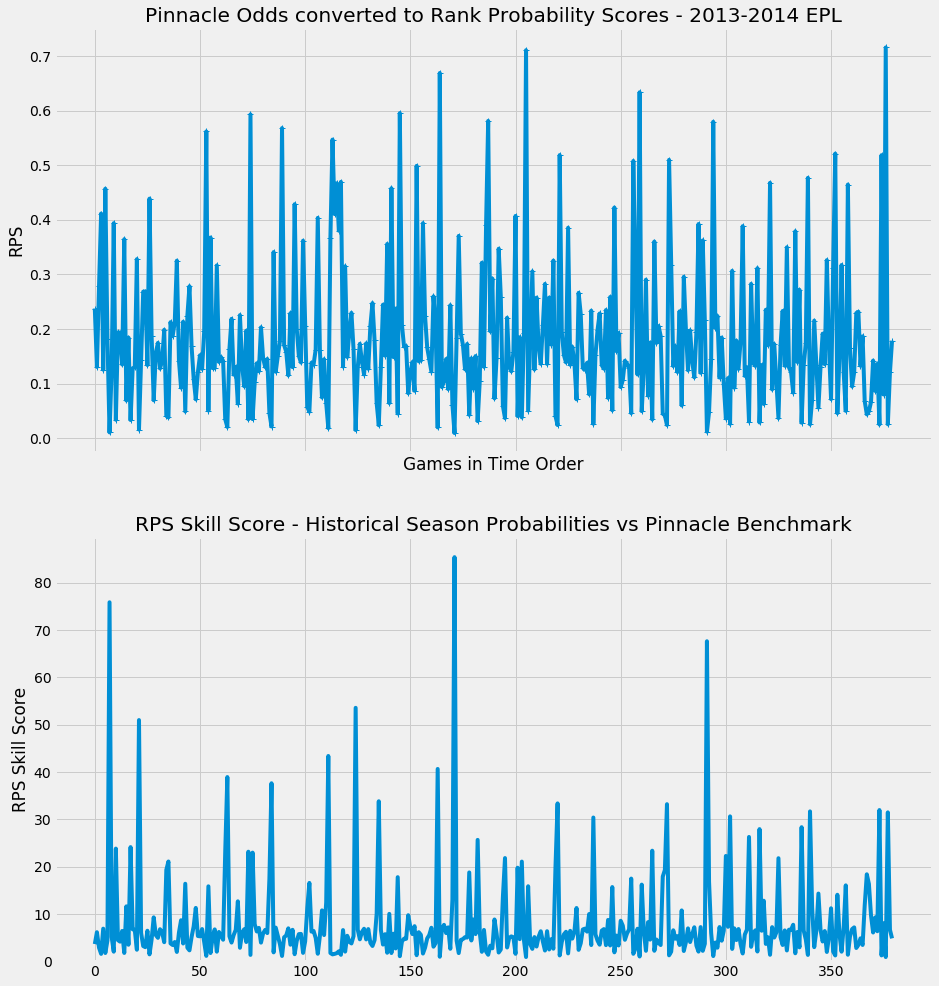

In [20]:
plt.style.use('fivethirtyeight')
fig, (ax1,ax2) = plt.subplots(ncols=1, nrows=2,figsize=(14,16), sharex=True)


ax1.plot(df_coded.index, df_coded['pinn_RPS'], '+-')
#ax1.axvline(h_shots_mean, color='r')
ax1.set_title('Pinnacle Odds converted to Rank Probability Scores - 2013-2014 EPL')
ax1.set_xlabel('Games in Time Order')
ax1.set_ylabel('RPS')

ax2.plot(df_coded.index, df_coded['RPS_SS'])#shots_dists['a_shots'], color='b', alpha=0.5, label='Away Shots')
ax2.set_title('RPS Skill Score - Historical Season Probabilities vs Pinnacle Benchmark')
ax2.set_ylabel('RPS Skill Score')
ax2.set_ylim(0)

plt.show();

This is interesting!

## Sklearn custom Scoring

In [21]:
def rps_mean(estimator, X: np.ndarray, y: np.ndarray) -> float:
    """
    https://scikit-learn.org/stable/modules/model_evaluation.html#implementing-your-own-scoring-object
    Accepts:
    a scikit learn estimator model - estimator must have a predict_proba method
    X - data used to make prediction - validation data
    y = ground truth
    
    !!!!!!!!!!!
    """
    # Convert the y to a one hot encoded DataFrame in same sequence as prediction probas
    
    # Deal with situation where all classes not in y
    # Get the missing classes
    missing_classes = set(estimator.classes_) - set(y.unique())
    # Get ys as a DataFrame
    y_encoded = pd.get_dummies(y)
    if missing_classes:
        for missing_class in missing_classes:
            # Insert missing class into y encoded as 0
            y_encoded[missing_class] = 0
            
    # Put y matrix into the same column order as the probability predictions
    y_encoded = y_encoded[estimator.classes_]
        
    # Get the probabilities into a DataFrame
    pred_df = pd.DataFrame(estimator.predict_proba(X))
    
    # Cumulative Distributions
    pred_cdf = pd.DataFrame(pred_df).cumsum(axis='columns').values
    obs_cdf = y_encoded.cumsum(axis='columns').values
    # RPS Calculation and get sum
    # each prediction set could be a different length, so divide the sum by the number of pred observations
    #RPS = pd.Series(np.sum(1/(pred_df.shape[1]-1) * (pred_cdf - obs_cdf)**2, 1), name='RPS').sum()/len(y)
    mean_RPS = pd.Series(np.sum(1/(pred_df.shape[1]-1) * (pred_cdf - obs_cdf)**2, 1), name='RPS').mean()
    # Negate return because for RPS lower is better, but for sklearn scorer higher is better
    return -mean_RPS